# We will predict digits of MNIST dataset using KNN classifier 

## Let's import necesssary libraries

In [29]:
from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsClassifier
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

#To plot fancy looking plots
%matplotlib inline

import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
matplotlib.rc('axes', labelsize=14)
matplotlib.rc('xtick', labelsize=12)
matplotlib.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "MNIST"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

# custom function to save the images on which we are gonna work
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)



In [8]:
# We have taken as_frame = False, so that we can work on numpy arrays. If we exclude this parameter then we will get a panda dataframe as the dataset. 
dataset = fetch_openml('mnist_784', version=1, as_frame=False) 


In [9]:
# Let's see what type of catagories we are gonna face from this dataset! If you are using the panda dataframe, then use head() instead of keys() 
dataset.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

### Sk-learn gives us this dataset pre-modified. So we have a dataset where the sample set and label/target set are already classified and also shuffled!

In [10]:
# data = Our sample data class
# target = Our labels
X,Y = dataset["data"], dataset["target"]
X.shape

(70000, 784)

In [37]:
Y.shape

(70000,)

### Our main aim is to detect the digits from the images. So this is a classification issue in the language of ML. We are break this code into 2 parts: 1) We are gonna select one image and train our model to detect that image correcly (This process is called Binary Classifier).  2) We are gonna consider the whole dataset to train our model and predict the digits. In both cases we are gonna use KNN algorithm.

Saving figure target_digit_plot


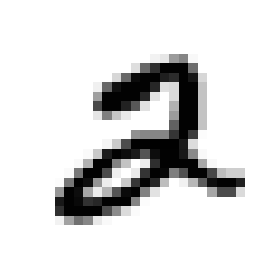

In [11]:
# Let's choose a random image from our sample set
target_digit = X[5]
target_digit_img = target_digit.reshape(28,28)  # We are reshaping this data so that it can be plotted as an image
plt.imshow(target_digit_img, cmap = matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
save_fig("target_digit_plot")
plt.show()

In [46]:
Y[5] # We can see that our labels are in the string format! But we will use integer format so that we can use these data for calculation afterward

'2'

In [12]:
Y = Y.astype(np.uint8)   # Converting strings to integers
Y[5]

2

In [13]:
# SK-learn gives us this set with predefined train and test set! The first 60000 data is for training purpose and rest are for testing purpose. If you want to use change this ratio then you can do that. But that might hamper your model training.
X_train, X_test, y_train, y_test = X[:60000], X[60000:], Y[:60000], Y[60000:]   

In [14]:
y_train_2 = (y_train == 2)  # We are taking our target label for both train and test set for now
y_test_2 = (y_test == 2)

In [15]:
knn_classifier = KNeighborsClassifier(n_neighbors=3)
knn_classifier.fit(X_train, y_train_2)

KNeighborsClassifier(n_neighbors=3)

In [16]:
knn_classifier.predict([target_digit]) 

array([ True])

In [17]:
# We can see that our model could predict correctly! But we will run some evaluation tests for assurance
# We will now apply the cross validation test and find out the accuracy of our model for 3 consecutive validations
cross_val_score(knn_classifier, X_train, y_train_2, cv=3, scoring="accuracy")

array([0.99415, 0.99495, 0.9943 ])

In [59]:
# Our accuracy is really good. But this is not good in the sense of ML. We might have overfitted our model. Let's check the confusion matrix to find out the model predictions precisely. 
y_train_prediction = cross_val_predict(knn_classifier, X_train, y_train_2, cv=3)

In [61]:
confusion_matrix(y_train_2,y_train_prediction)

array([[53979,    63],
       [  269,  5689]], dtype=int64)

In [62]:
precision_score(y_train_2,y_train_prediction)

0.989047287899861

In [63]:
recall_score(y_train_2,y_train_prediction)

0.9548506210137631

In [64]:
f1_score(y_train_2,y_train_prediction)

0.9716481639624253

In [71]:
# So our confusion matrices gave pretty good scores till now. It means we are on the right track. Seeing these scores, we can directly say that our model is doing good for this particular image. But for the sake of investigation, we will draw the ROC curve to find out the relation between True positive rates and False positive rates.

y_knn_predictions = cross_val_predict(knn_classifier, X_train, y_train_2, cv=3,
method="predict_proba")
# We have used the method predict proba to get the predicted scores of our training set. It is required for drawing the ROC Curve.

In [72]:
y_knn_predictions.shape
# We can see that it is a 2D data. But we can only use a 1D data for the curve!

(60000, 2)

In [73]:
y_scores = y_knn_predictions[:, 1] # So we are taking only the 1st column of the predicted scores

In [89]:
fpr, tpr, thresholds = roc_curve(y_train_2, y_scores)

Saving figure roc_curve_plot


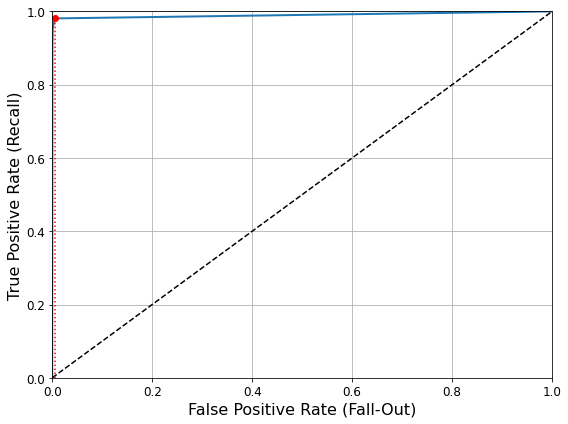

In [90]:
# Let's draw a fancy function for drawing a fancy looking ROC Curve

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                                    # Not shown
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           # Not shown
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   # Not shown
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  # Not shown
plt.plot([fpr_90], [recall_90_precision], "ro")               # Not shown
save_fig("roc_curve_plot")                                    # Not shown
plt.show()
# Till now it is good enough. As we are using KNN classifier, this graph is not important for our model training. Because ROC curve is used to determine the threshold of a binary classifier or for plotting two different curves of two different algorithms and determine which is better using the AUC.

### Now we will take first 1000 image set to train our model and predict the digits

In [91]:

knn_classifier.fit(X_train[:1000], y_train[:1000])
knn_classifier.predict([target_digit])

array([2], dtype=uint8)

In [93]:
# Our model predicts correctly! But still we will go for cross validation just like we did before.
target_digit_scores = knn_classifier.predict_proba([target_digit]) # We are taking the prediction score for out target label
target_digit_scores

array([[0.        , 0.        , 0.66666667, 0.        , 0.        ,
        0.33333333, 0.        , 0.        , 0.        , 0.        ]])

In [19]:

cross_val_score(knn_classifier, X_train, y_train, cv=3, scoring="accuracy")


[array([0.969  , 0.96805, 0.9675 ])]

In [96]:
# We can see that out prediction is 96% accurate on an average!
# We will now scale our data so that we can avoid any unnecessary fitting error
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(knn_classifier, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.93755, 0.9406 , 0.94085])

In [97]:
# We can see that our prediction accuracy has decreased to 93% now. So we will check the confusion matrix
y_train_pred = cross_val_predict(knn_classifier, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5830,    4,   16,    5,    0,   19,   41,    3,    2,    3],
       [   2, 6674,   17,   10,    9,    2,   13,    7,    6,    2],
       [  77,   67, 5547,   88,   30,    9,   46,   44,   30,   20],
       [  24,   29,   76, 5749,    5,   92,    6,   62,   60,   28],
       [   9,   69,   50,    7, 5425,   11,   23,   32,   11,  205],
       [  36,   20,   20,  184,   15, 4969,   83,   12,   41,   41],
       [  72,   15,   15,    7,   13,   55, 5735,    1,    5,    0],
       [  12,   63,   37,   15,   76,    2,    0, 5839,    4,  217],
       [  65,   88,   58,  137,   62,  188,   27,   17, 5146,   63],
       [  21,   14,   25,   54,  124,   15,    1,  217,   12, 5466]],
      dtype=int64)

Saving figure confusion_matrix_plot


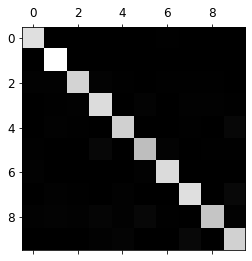

In [98]:
# This is a big array! Let's just plot a graph for better visualization
plt.matshow(conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_plot", tight_layout=False)
plt.show()

In [100]:
# Great! Our prediction looks good. 
# For increasing the accuracy we are gonna work on the hyperparameters of KNN now. We are use Grid Search to determine the best params of KNN for this model.
param_grid = [{'weights': ["uniform", "distance"], 'n_neighbors': [3, 4, 5]}]
grid_search = GridSearchCV(knn_classifier, param_grid, cv=5, verbose=3)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END .................n_neighbors=3, weights=uniform; total time=  46.1s
[CV 2/5] END .................n_neighbors=3, weights=uniform; total time=  43.8s
[CV 3/5] END .................n_neighbors=3, weights=uniform; total time=  45.0s
[CV 4/5] END .................n_neighbors=3, weights=uniform; total time=  44.0s
[CV 5/5] END .................n_neighbors=3, weights=uniform; total time=  42.9s
[CV 1/5] END ................n_neighbors=3, weights=distance; total time=  42.9s
[CV 2/5] END ................n_neighbors=3, weights=distance; total time=  43.6s
[CV 3/5] END ................n_neighbors=3, weights=distance; total time=  42.3s
[CV 4/5] END ................n_neighbors=3, weights=distance; total time=  41.6s
[CV 5/5] END ................n_neighbors=3, weights=distance; total time=  41.7s
[CV 1/5] END .................n_neighbors=4, weights=uniform; total time=  51.3s
[CV 2/5] END .................n_neighbors=4, weig

GridSearchCV(cv=5, estimator=KNeighborsClassifier(n_neighbors=3),
             param_grid=[{'n_neighbors': [3, 4, 5],
                          'weights': ['uniform', 'distance']}],
             verbose=3)

In [101]:
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [103]:
y_pred = grid_search.predict(X_test)
accuracy_score(y_test, y_pred)

0.9714

In [26]:
# Great! Now we have an accuracy level of 97%, with scaled data and standard precision and recall scores. But as we are machine learning engineers, automation always suits us, Right?
# To give our training a fancy outlook, now we will go for automating this project.

def mnist_knn_pipeline( dataset_sample, dataset_label, target_digit_pos, cross_valid = False):
    X,Y = dataset_sample, dataset_label
    target_digit = X[target_digit_pos]
    target_digit_img = target_digit.reshape(28,28)  
    plt.imshow(target_digit_img, cmap = matplotlib.cm.binary, interpolation="nearest")
    plt.axis("off")
    save_fig("target_digit_plot")
    plt.show()
    
    X_train, X_test, y_train, y_test = X[:60000], X[60000:], Y[:60000], Y[60000:]   
    
    knn_classifier = KNeighborsClassifier(n_neighbors=3)
    knn_classifier.fit(X_train[:1000], y_train[:1000])
    
    if (cross_valid == True):
        
        cross_valid_score = cross_val_score(knn_classifier, X_train, y_train, cv=3, scoring="accuracy")
        for c in cross_valid_score:
            if (c > 90 ):
                scaler = StandardScaler()
                X_train = scaler.fit_transform(X_train.astype(np.float64))
                cross_valid_score = cross_val_score(knn_classifier, X_train_scaled, y_train, cv=3, scoring="accuracy")
                break
    
    
    
    y_train_pred = cross_val_predict(knn_classifier, X_train, y_train, cv=3)
    conf_mx = confusion_matrix(y_train, y_train_pred)
    conf_mx
    
    plt.matshow(conf_mx, cmap=plt.cm.gray)
    save_fig("confusion_matrix_plot", tight_layout=False)
    print("Confusion Matrix Plot")
    plt.show()
    
    param_grid = [{'weights': ["uniform", "distance"], 'n_neighbors': [3, 4, 5]}]
    grid_search = GridSearchCV(knn_classifier, param_grid, cv=5, verbose=3)
    grid_search.fit(X_train, y_train)
    
    grid_search_best_params = grid_search.best_params_
    y_pred = grid_search.predict(X_test)
    target_predict = grid_search.predict([target_digit])
    acc_score = accuracy_score(y_test, y_pred)
    
    result = {"Predicted Digit: ": target_predict, "Accuracy: ": acc_score, "Cross Validation Score: ": cross_valid_score}
    
    return result


Saving figure target_digit_plot


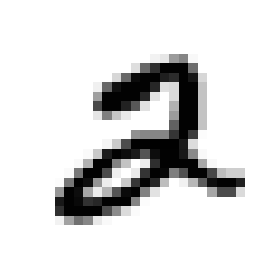

Saving figure confusion_matrix_plot
Confusion Matrix Plot


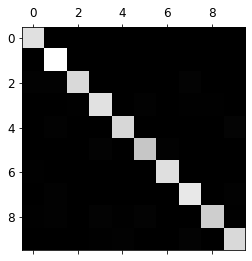

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END .................n_neighbors=3, weights=uniform; total time=  31.5s
[CV 2/5] END .................n_neighbors=3, weights=uniform; total time=  33.7s
[CV 3/5] END .................n_neighbors=3, weights=uniform; total time=  34.2s
[CV 4/5] END .................n_neighbors=3, weights=uniform; total time=  34.6s
[CV 5/5] END .................n_neighbors=3, weights=uniform; total time=  34.1s
[CV 1/5] END ................n_neighbors=3, weights=distance; total time=  32.9s
[CV 2/5] END ................n_neighbors=3, weights=distance; total time=  36.0s
[CV 3/5] END ................n_neighbors=3, weights=distance; total time=  34.0s
[CV 4/5] END ................n_neighbors=3, weights=distance; total time=  30.3s
[CV 5/5] END ................n_neighbors=3, weights=distance; total time=  31.2s
[CV 1/5] END .................n_neighbors=4, weights=uniform; total time=  40.3s
[CV 2/5] END .................n_neighbors=4, weig

{'Predicted Digit: ': array(['2'], dtype=object),
 'Accuracy: ': 0.9714,
 'Cross Validation Score: ': array([0.969  , 0.96805, 0.9675 ])}

In [27]:
Result = mnist_knn_pipeline(dataset["data"], dataset["target"], 5, cross_valid = True)
Result